# Plots
Cascade Tuholske Aug 2021

Make plots of dist binned population from GHCN/GSOD stations 

In [1]:
import os
import rasterio
from rasterio import features
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point 
import matplotlib.pyplot as plt
import numpy as np

### Turn CHIRTS-daily GHCN/GSOD stations into points

In [2]:
# Open Stations
stations_fn = os.path.join('/Users/cpt2136/Github/UrbanHeat/data/CHIRTS-daily/ValidationData/Validated/GHCN-and-GSOD-CHIRTSTmax_ERA5_meta-with-validation.csv')
stations = pd.read_csv(stations_fn)
stations.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)

# Turn into gdf
stations['geometry'] = [Point(xy) for xy in zip(stations['longitudes'], stations['latitudes'])] # creating a geometry column 
crs = {'init': 'epsg:4326'} # Coordinate reference system : WGS84
stations_gdf = gpd.GeoDataFrame(stations, crs=crs)

# get geom 
stations_pnt = gpd.GeoDataFrame(stations_gdf['geometry'])

/Users/cpt2136/miniconda3/envs/geo38/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Burn Arrays

In [3]:
def buffer_burn(points_in, buff_dist, touch = False):
    
    """ Takes points, buffers them and burns them into an array, all touched is set to False by defualt. 
    Returns burned array.
    Args:
        polys_in = points to buffer
        buff_dist = distance to buffer, in degrees
        touch = all touch or no touch burn, see rasterio documentation
    """
    
    # buffer polys
    buffer = gpd.GeoDataFrame(geometry = points_in.buffer(buff_dist))
    buffer['ID'] = 1
    
    # Burn array
    ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
    ghs = rasterio.open(ghs_fn) # base map

    meta = ghs.meta.copy() # copy meta data from rst
    arr = ghs.read(1) # get an array to burn shapes
    arr.fill(0) # revalue rst to an Nan Value before burning in polygons 

    # extract geom and values to burn
    shapes = ((geom,value) for geom, value in zip(buffer['geometry'], buffer['ID'])) 

    # burn shapes into an array - Using no touch see rasterstats zonal stats documentation for justification 
    burned = features.rasterize(shapes=shapes, fill=0, out=arr, transform=ghs.transform, all_touched=touch)
    
    return burned

In [4]:
# buff 1k, 5k, 10k, 25k - error is ok, we're using unprojected data and this a-OK for this project
buff_1k = buffer_burn(points_in = stations_pnt, buff_dist = 0.01, touch = False)
buff_5k = buffer_burn(points_in = stations_pnt, buff_dist = 0.05, touch = False)
buff_10k = buffer_burn(points_in = stations_pnt, buff_dist = 0.1, touch = False)
buff_25k = buffer_burn(points_in = stations_pnt, buff_dist = 0.25, touch = False)

<ipython-input-3-505a9c03b915>:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gpd.GeoDataFrame(geometry = points_in.buffer(buff_dist))


In [13]:
# buff differences
buff_1_5k = buff_1k + buff_5k
buff_1_5k[buff_1_5k > 1] = 0

buff_5_10k = buff_5k + buff_10k
buff_5_10k[buff_5_10k == 2] = 0

buff_10_25k = buff_10k + buff_25k
buff_10_25k[buff_10_25k == 2] = 0 

In [19]:
# > 25 K
buff_25k_plus = buff_25k.copy()

# invert
buff_25k_plus[buff_25k_plus == 1] = 2
buff_25k_plus[buff_25k_plus == 0] = 1
buff_25k_plus[buff_25k_plus == 2] = 0

# add in the middle
# buff_25k_plus = buff_25k_plus + buff_10_25k + buff_5_10k + buff_1_5k + buff_1k
# buff_25k_plus[buff_25k_plus > 1] == 0

In [20]:
# save out buffers - update arr_out and out_fn 
ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
ghs = rasterio.open(ghs_fn) # base map

meta = ghs.meta.copy() # copy meta data from rst
arr = ghs.read(1) # get an array to burn shapes

# name them 
arr_out = buff_25k_plus
out_fn = os.path.join('../data/interim/GHCN-GSOD-25k-plus.tif')

# write the raster
with rasterio.open(out_fn, 'w', **meta) as out:
    out.write_band(1, arr_out)

### Urban Arrays

In [21]:
smod_fn = os.path.join('../data/interim/GHS-SMOD15-UrbanRural-Matched.tif')
smod_arr = rasterio.open(smod_fn).read(1)

In [22]:
# smod -200 = NaN, 10 = Water, 111 = Rural, 222 = Urban
urban = smod_arr.copy()
urban[urban == 111] = 0 # set rural to zero 
urban[urban == 10] = 0 # set water to zero
urban[urban == -200] = 0 # set nana to zero
urban[urban == 222] = 1 # set urban to 1


In [23]:
# make urban arrays
urban_1k = buff_1k * urban
urban_1_5k = buff_1_5k * urban
urban_5_10k = buff_5_10k * urban
urban_10_25k = buff_10_25k * urban
urban_25k_plus = buff_25k_plus * urban

In [24]:
# check number of pixels
print('urban', np.count_nonzero(urban_1k == 1))
print('all', np.count_nonzero(buff_1k == 1))
gut = buff_1k * urban_1k
print('gut check', np.count_nonzero(gut == 1))

urban 15883
all 59328
gut check 15883


### Gut Check

In [25]:
# check number of pixels
print('urban', np.count_nonzero(urban_1k == 1))
print('all', np.count_nonzero(buff_1k == 1))
gut = buff_1k * urban_1k
print('gut check', np.count_nonzero(gut == 1))

urban 15883
all 59328
gut check 15883


In [26]:
# get populations
ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
ghs_arr = rasterio.open(ghs_fn).read(1)

In [27]:
gut = ghs_arr.copy()

In [28]:
gut[gut < 1] = 0
gut[gut >= 1] = 1

In [29]:
# check number of pixels
print('ghs', np.count_nonzero(gut == 1))


ghs 21811071


In [30]:
tot = gut * buff_1k
print('all', np.count_nonzero(tot == 1))
tot_urban = gut * urban_1k
print('ghs urban', np.count_nonzero(tot_urban == 1))

all 41180
ghs urban 15380


In [31]:
gut = ghs_arr.copy()
gut[gut < 1] = 0
tot = gut * buff_1k
print('all', np.count_nonzero(tot == 1))
tot_urban = gut * urban_1k
print('ghs urban', np.count_nonzero(tot_urban == 1))

all 0
ghs urban 0


In [32]:
print('tot sum', tot.sum() /10**6)
print('urban sum', tot_urban.sum()/10**6)

tot sum 38.830341638166324
urban sum 35.70333818907231


### Totals

In [33]:
def tot_pop(arr):
    tot = (arr * ghs_arr).sum()
    
    return tot

In [34]:
# get populations
ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
ghs_arr = rasterio.open(ghs_fn).read(1)

In [35]:
# remove nan -999 values from ghs pop
ghs_arr[ghs_arr < 1] = 0

In [36]:
# totals 
tot_1k = tot_pop(buff_1k)
tot_1_5k = tot_pop(buff_1_5k)
tot_5_10k = tot_pop(buff_5_10k)
tot_10_25k = tot_pop(buff_10_25k)
tot_25k_plus = tot_pop(buff_25k_plus)

In [37]:
# list 
totals = [tot_1k, tot_1_5k, tot_5_10k, tot_10_25k, tot_25k_plus]


In [42]:
# World population
print('world', ghs_arr.sum() /10**9)
print('totals',sum(totals))

world 7.343308261288027
totals 7343308261.288019


In [43]:
# Urban totals
tot_urban_1k = tot_pop(urban_1k)
tot_urban_1_5k = tot_pop(urban_1_5k)
tot_urban_5_10k  = tot_pop(buff_5_10k)
tot_urban_10_25k = tot_pop(urban_10_25k)
tot_urban_25k_plus = tot_pop(urban_25k_plus)

In [45]:
# list
urban_totals = [tot_urban_1k, tot_urban_1_5k, tot_urban_5_10k, tot_urban_10_25k, tot_urban_25k_plus] 


In [46]:
# World population
print('world urban', (ghs_arr * urban).sum())
print('urban totals', sum(urban_totals))

world urban 5321867504.070008
urban totals 5398757477.008375


### Plot

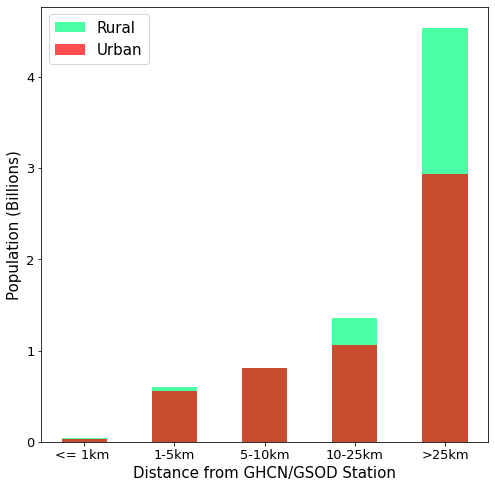

In [59]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

locs = [1,2,3,4,5]

# All
data = [tot_1k, tot_1_5k, tot_5_10k, tot_10_25k, tot_25k_plus]
data = [x / 10**9 for x in data]
plt.bar(locs, data, color = 'springgreen', alpha = 0.7, width=0.5)

# Urban 
data = [tot_urban_1k, tot_urban_1_5k, tot_urban_5_10k, tot_urban_10_25k, tot_urban_25k_plus] 
data = [x / 10**9 for x in data]
plt.bar(locs, data, color = 'red', alpha = 0.7, width=0.5)

# Labels & ticks
labels = ['<= 1km ', '1-5km', '5-10km', '10-25km', '>25km'];
plt.xticks([1,2,3,4,5], labels, fontsize = 13);
plt.xlabel('Distance from GHCN/GSOD Station', fontsize = 15)
plt.ylabel('Population (Billions)', fontsize = 15)
plt.yticks(fontsize = 13);

# legend
leg = ['Rural', 'Urban']
plt.legend(leg, fontsize = 15)

In [ ]:
# All
tots = [tot_1k, tot_1_5k, tot_5_10k, tot_10_25k, tot_25k_plus]

# Urban 
urbans = [tot_urban_1k, tot_urban_1_5k, tot_urban_5_10k, tot_urban_10_25k, tot_urban_25k_plus] 


In [ ]:
sum(urbans) / 10**9

In [ ]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

# All Quake
data = group(npl_all)

# Bar locations
a = [1-.3,2-.3,3-.3, 4-.3]
b = [1-.15,2-.15,3-.15,4-.15]
c = [1,2,3,4]
d = [1+.15,2+.15,3+.15,4+.15]
e = [1+.3,2+.3,3+.3,4+.3]

# plots
plt.bar(a, data.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, data.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, data.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black')
plt.bar(d, data.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

# Fake plot for rural hatch legend 
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0, color = 'white', ec = 'black',hatch = "///")

# rural floods
data = group(npl_rural)
plt.bar(a, data.ESRI16_sum / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, data.GHS15_sum / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, data.GPWv4_sum / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black', hatch = "///")
plt.bar(d, data.LS15_sum / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, data.WP16_sum / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# legend
legend_elements = [Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  Patch(facecolor=GHS15_c, alpha = 0.6, edgecolor=None, label='GHSL-15'),
                  Patch(facecolor=GPWv4_c, alpha = 0.7, edgecolor=None, label='GPW-15'),
                  Patch(facecolor=LS15_c, alpha = 0.8, edgecolor=None, label='LS-15'),
                  Patch(facecolor= WP16_c, alpha = 0.9, edgecolor=None, label='WP-16'),
                  Patch(facecolor= 'white', alpha = 0.9,  hatch = '///', edgecolor='black', label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

# Labels / Titles
axs.set_title('Nepal 2015 Earthquake Impact', size = 20)
axs.set_xlabel('Instrumental Intesnity', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# Ticks
ticks_bar = ['>=4', ' >=5', '>=6', '>=7'];
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15);
plt.yticks(fontsize = 15);

# save it out
fig_out = DATA_PATH+'FIGS/MS/Finalv1/Fig4.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')